Osnabrück University - Computer Vision (Winter Term 2020/21) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack, Axel Schaffland

# Exercise Sheet 05: Segmentation 2

## Introduction

This week's sheet should be solved and handed in before the end of **Saturday, December 5, 2020**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (Periodic functions) [0 Points]

This exercise is supposed to be very easy, does not give any points, and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up again. You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What are periodic functions? Can you provide a definition?

YOUR ANSWER HERE

**b)** What are *amplitude*, *frequency*, *wave length*, and *phase* of a sine function? How can you change these properties?

YOUR ANSWER HERE

**c)** How are sine and cosine defined for complex arguments? In what sense does this generalize the real case?

YOUR ANSWER HERE

## Assignment 1: Edge-based segmentation  [5 Points]

### a) Gradients
What is the gradient of a pixel? How do we calculate the first, how the second derivative of an image?  

The gradient of a pixel is given by the difference in contrast to its neighboring pixels (4- or 8-neighborhood). The gradient points into the direction with highest divergence. We can imagine an image as a function consisting of two variables (x- and y-axes) and its color shading in each pixel as the outcome. The whole image presents a landscape of valleys and hills in respect to it shading and coloring. A sobel-filtered image presents the first derivative of each pixel while the laplace-filter creates the second derivative. 

### b) Edge linking

Describe in your own words the idea of edge linking. What is the goal? Why does it not necessarily yield closed
edge contours?

In general edge linking searches for the next unprocessed and free edge pixel and tries to merge it with other already processed pixels to form an continous edge.

The edge linking algorithm is not able to link associated edge pixels if the gaps between these pixels are too large. Thus blurred images with a bad resolution lead to not closed edge contours.

### c) Zero crossings

Explain what zero crossings are. Why does the detection of zero crossings always lead to closed contours?

Zero crossings are the positions in the second derivative of an image (laplace filtered) where the curve of the graph crosses the x-axis (the value 0).  

The detection of zero crossings leads always to closed contours, because the zero crossings correspond to connected segments in the original image. Thus by detecting zero-crossings in the second derivative one can infer a closed contour in the original image.

### c) Zero crossings (implementation)

Provide an implementation of the zero crossing procedure described in (CV-07 slide 71). To get sensible results you should smooth the image before applying the Laplacian filter, e.g. using the Laplacian of a Gaussian (you may use buildin functions for the filterings steps).

[[-9.97625613e-04 -2.62331495e-04  1.06272978e-03 ...  6.29404105e-03
   9.89966299e-03  1.03075214e-02]
 [-1.09911152e-03 -5.64874387e-04  7.18060662e-04 ...  9.21989890e-03
   6.31510417e-03 -1.78462010e-03]
 [-6.72104779e-04  2.87224265e-05  1.34420956e-03 ...  2.97564338e-03
  -6.93550858e-03 -1.70802696e-02]
 ...
 [ 8.82735907e-04  1.12974877e-04 -3.63817402e-04 ... -9.55307904e-03
  -3.25712316e-03  1.56632966e-03]
 [-6.70189951e-05 -6.56786152e-04 -5.84022672e-04 ... -3.38350184e-03
   1.47441789e-04  3.04649203e-03]
 [-9.68903186e-04 -1.64483762e-03 -1.43803615e-03 ...  2.18098958e-03
   3.57881434e-03  5.58172488e-03]]


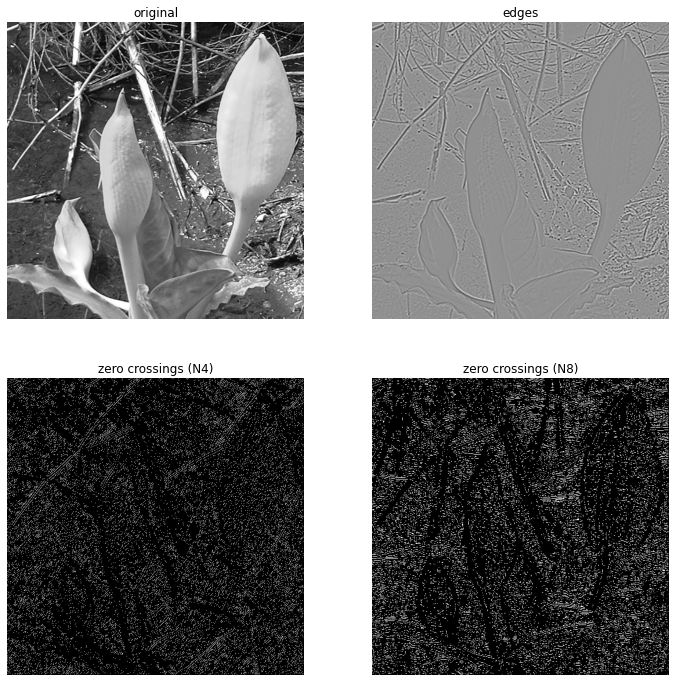

In [1]:
from skimage import filters
from imageio import imread
import matplotlib.pyplot as plt
import numpy as np
import scipy as sci
%matplotlib inline

img = imread('images/swampflower.png').astype(float)
img /= img.max()

kernel=np.asarray([1,4,6,4,1])
kernel=kernel.reshape(1,-1)
kernel=kernel.T@kernel

gaussian_filter_kernel = 1/256 * kernel

filtered_img = sci.ndimage.filters.convolve(img, gaussian_filter_kernel)

laplacian_operator =1/8*np.array([[0, 1, 0],
                               [1, -4, 1],
                               [0, 1, 0]])

filtered_img = sci.ndimage.filters.convolve(filtered_img, laplacian_operator)


print(filtered_img)

M,N = filtered_img.shape
zero_crossing_4=np.zeros((M,N))
zero_crossing_8=np.zeros((M,N))

for column_runner in range(M-1):
    for row_runner in range(N-1):
        check_1=filtered_img[column_runner][row_runner]*filtered_img[column_runner+1][row_runner]
        check_2=filtered_img[column_runner][row_runner]*filtered_img[column_runner][row_runner+1]
        check_3=filtered_img[column_runner][row_runner]*filtered_img[column_runner+1][row_runner-1]
        check_4=filtered_img[column_runner][row_runner]*filtered_img[column_runner+1][row_runner+1]
        #print(check_1,check_2)
        if check_1<=0 and check_2<=0:
            zero_crossing_4[column_runner][row_runner]=1
        if check_3<=0 and check_4<=0:
            zero_crossing_8[column_runner][row_runner]=1

# Now compute edges and then zero crossings using the 4-neighborhood and the 8-neighborhood
# YOUR CODE HERE

edges=filtered_img

zero_crossings_n4=zero_crossing_4
zero_crossings_n8=zero_crossing_8

plt.figure(figsize=(12, 12))
plt.gray()

plt.subplot(2,2,1); plt.axis('off'); plt.imshow(img); plt.title('original')
plt.subplot(2,2,2); plt.axis('off'); plt.imshow(edges); plt.title('edges')
plt.subplot(2,2,3); plt.axis('off'); plt.imshow(zero_crossings_n4); plt.title('zero crossings (N4)')
plt.subplot(2,2,4); plt.axis('off'); plt.imshow(zero_crossings_n8); plt.title('zero crossings (N8)' )

plt.show()

## Assignment 2: Watershed transform  [5 Points]



### a) Watershed transform

Explain in your own words the idea of watershed transform. How do the two different approaches from the lecture work? Why does watershed transform always give a closed contour?



The idea of watershed transform lays in the idea of "flooding" or "raining down on" an image from zero to the maximum grey value in the picture. For each level of water there is another label in the picture. Whenever two level "colide" a watershed is noted as the border between two segments in the picture. There is always a closed contour because the pixels need to be concatenated to others with the same label -> You can say even one pixel is a closed contour.

### b) Implementation

Now implement the watershed transform using the flooding approach (CV-07 slide 76, but note, that the algorithm presented there is somewhat simplified!). Obviously, buildin functions for computing watershed transform are not allowed, but all other functions may be used. In this example we appply the watershed transform to a distance transformed image, so you **do not** have to take the gradient image, but can apply the watershed transform directly.

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

TypeError: Image data of dtype object cannot be converted to float

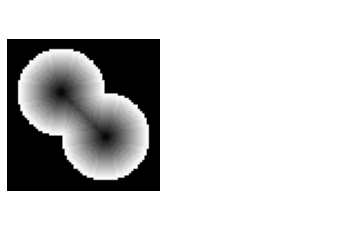

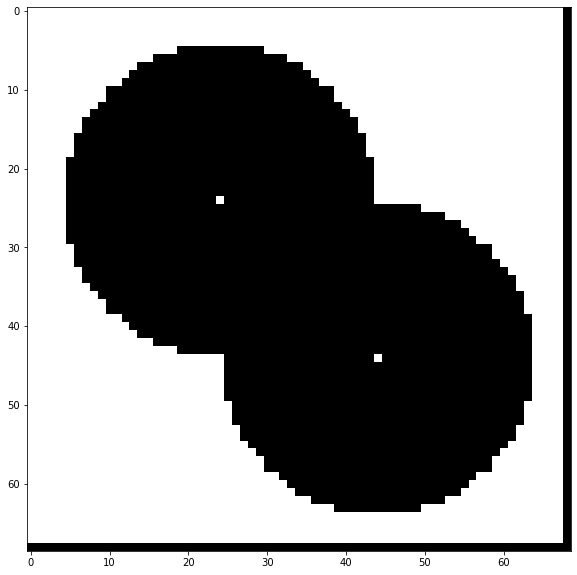

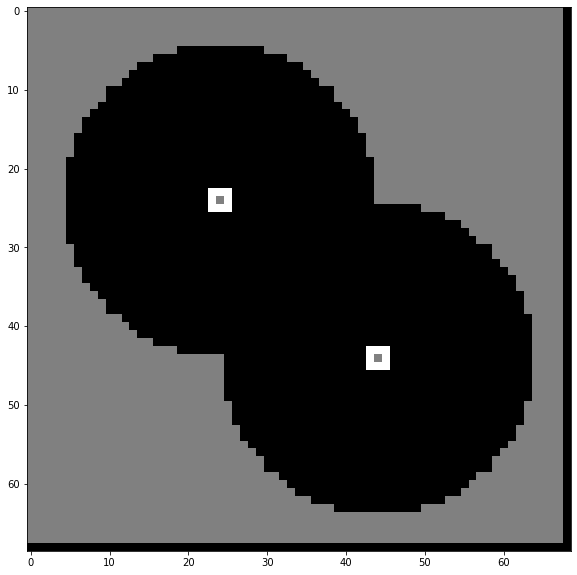

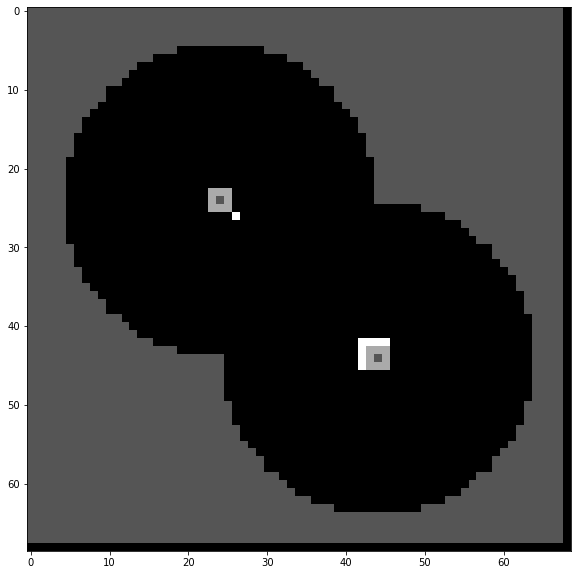

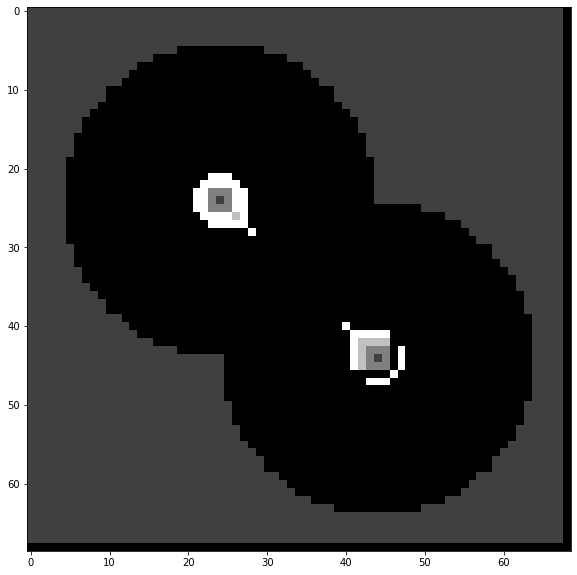

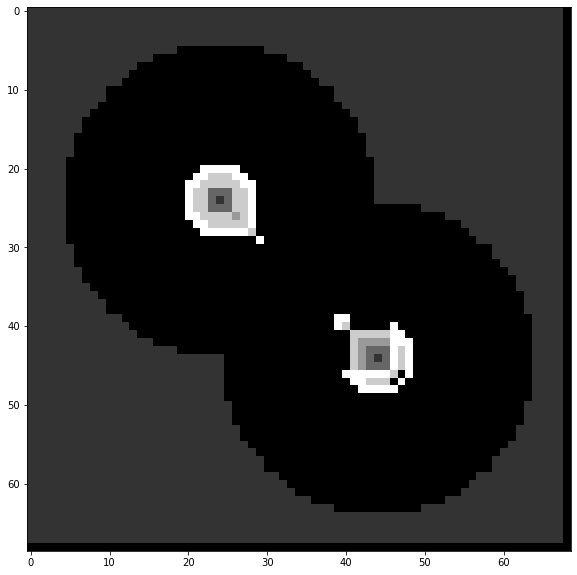

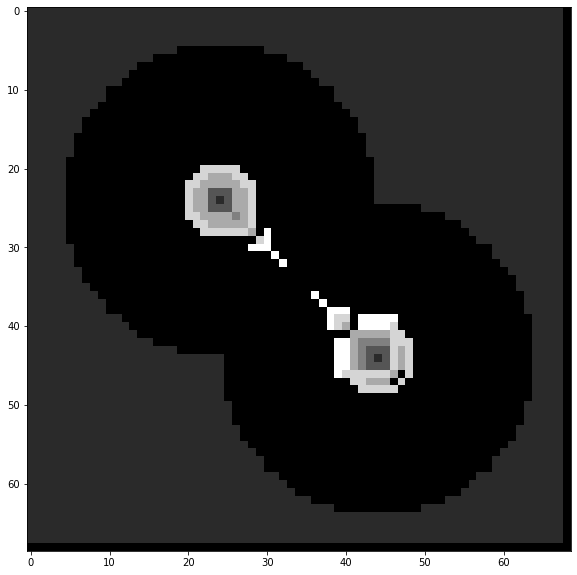

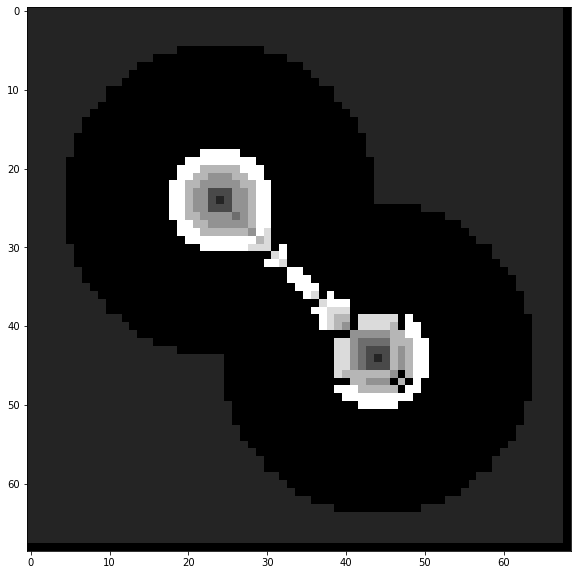

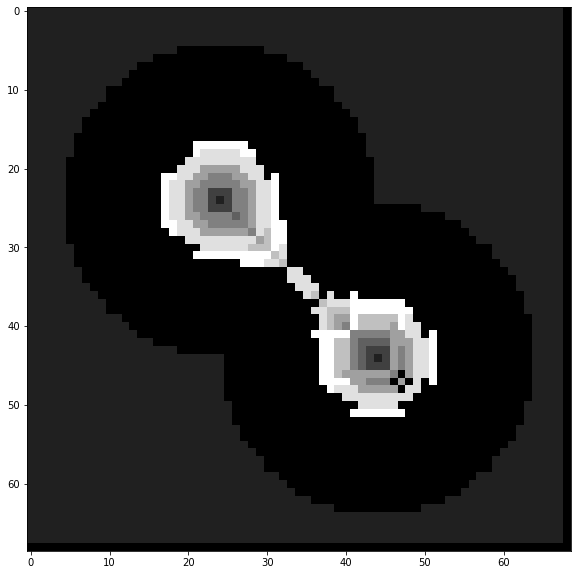

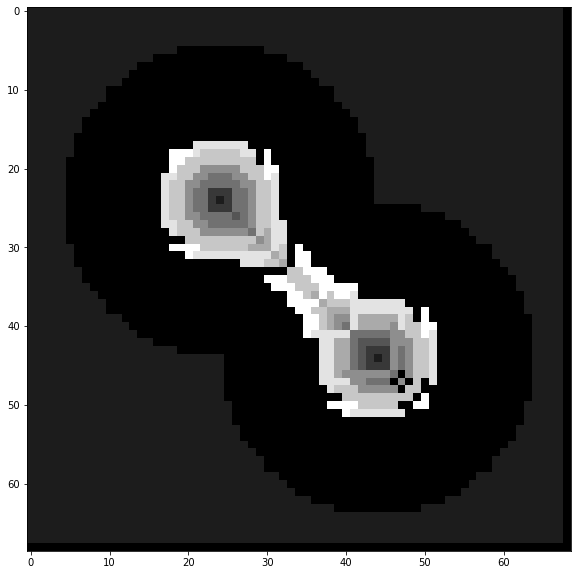

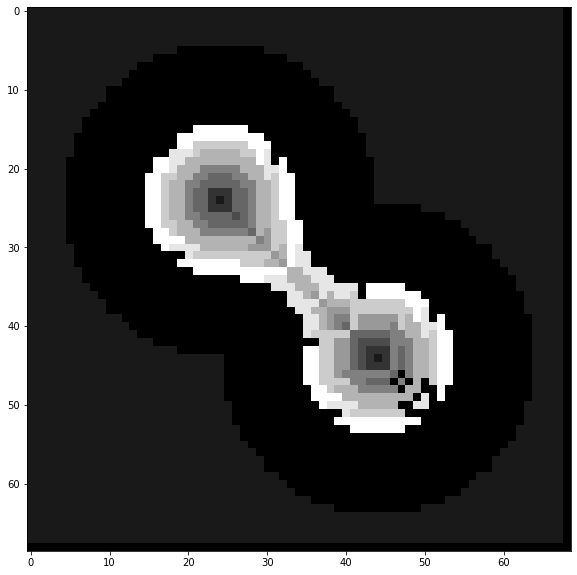

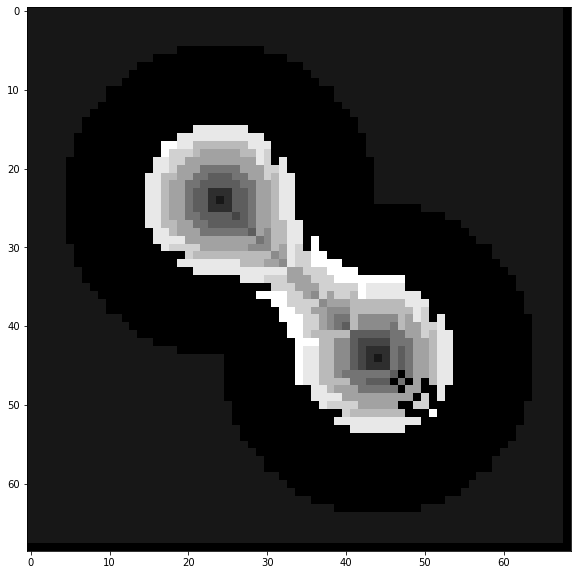

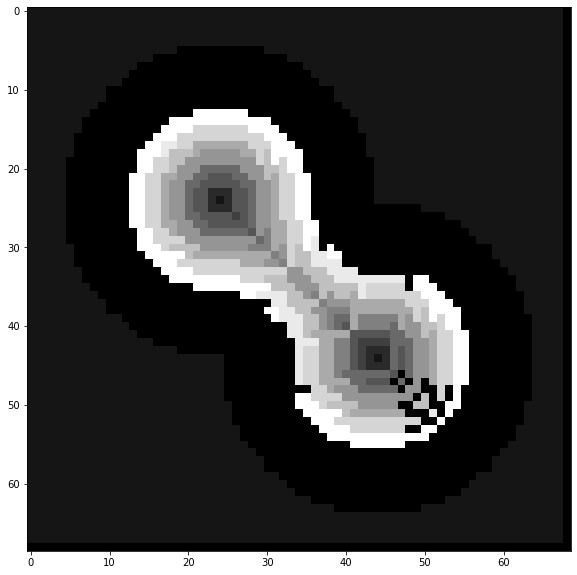

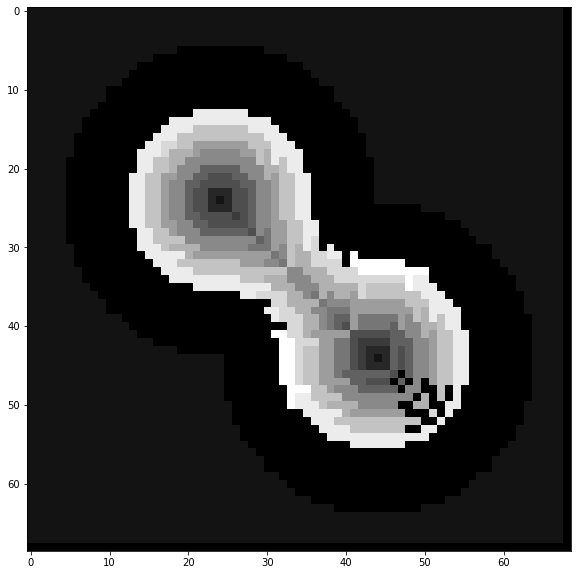

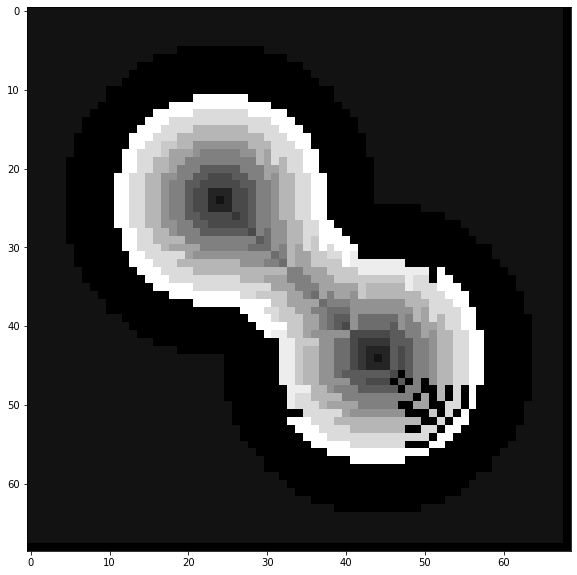

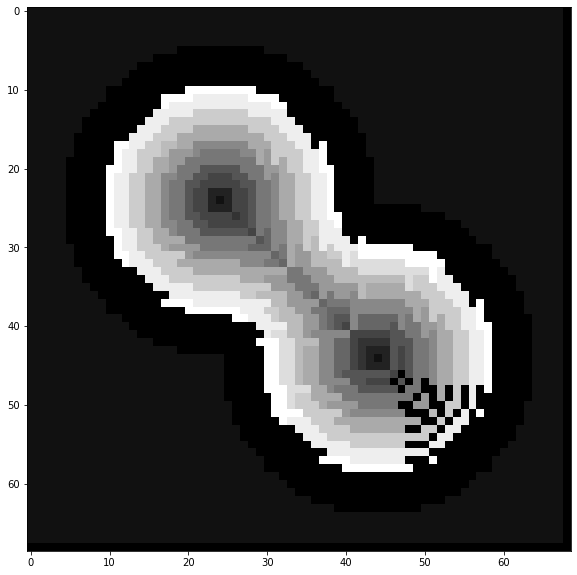

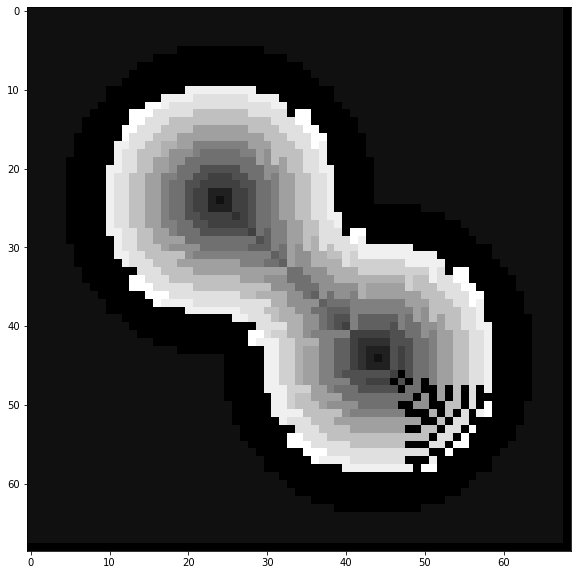

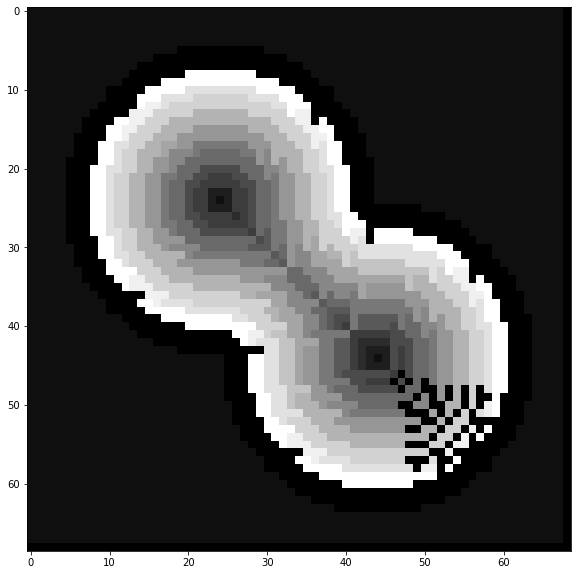

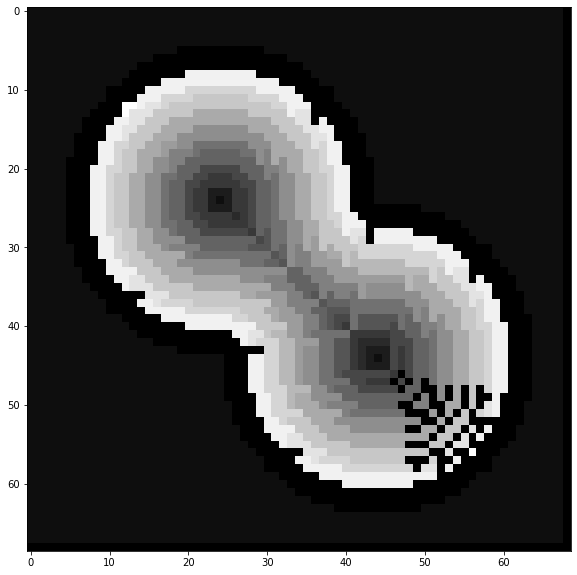

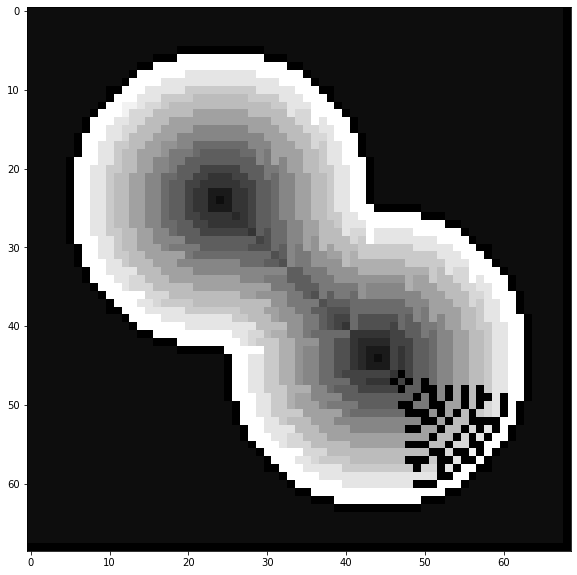

In [2]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import sys
import numpy

numpy.set_printoptions(threshold=sys.maxsize)
%matplotlib inline


def watershed(img, step=1):
    """
    Perform watershed transform on a grayscale image.
    
    Args:
        img (ndarray): The grayscale image.
        step (int): The rise of the waterlevel at each step. Default 1.
        
    Returns:
        edges (ndarray): A binary image containing the watersheds.
    """


    NO_LABEL = 0
    WATERSHED = 1
    new_label = 2
    
    water_level=0
    M,N=img.shape    

    row_runner=0
    column_runner=0
    active_label=0

    # initialize labels
    label = np.ones(img.shape, np.uint16)
    label=label*(-1)
    
    max_gradient=np.max(img)
  
    
    while water_level<max_gradient:

        for row_runner in range(M-1):
            for column_runner in range(N-1):
                if water_level>=img[row_runner][column_runner] and label[row_runner][column_runner]==-1:
                    
                    if label[row_runner+1][column_runner]==-1 and label[row_runner][column_runner+1]==-1 and label[row_runner-1][column_runner]==-1 and label[row_runner][column_runner-1]==-1:
                        label[row_runner][column_runner]=water_level
                        
                        #print("New label")
                        
                    elif label[row_runner+1][column_runner]==water_level:
                        label[row_runner][column_runner]=label[row_runner+1][column_runner]
                        
                        #print("Down label")
                      
                    elif label[row_runner][column_runner+1]==water_level:
                        label[row_runner][column_runner]=label[row_runner][column_runner+1]
                        
                        #print("Right label")
                     
                    elif label[row_runner-1][column_runner]==water_level:
                        label[row_runner][column_runner]=label[row_runner-1][column_runner]
                        
                        #print("Upper label")
                  
                    elif label[row_runner][column_runner-1]==water_level:
                        label[row_runner][column_runner]=label[row_runner][column_runner-1]
                        #print("Left label") 
                        
                    #if label[row_runner-1][column_runner]!=label[row_runner+1][column_runner] and label[row_runner-1][column_runner]!=1000 and label[row_runner+1][column_runner]!=1000: 
                        #label[row_runner][column_runner]=500
                        #print("Watershed Horizontal")
                    
                    #if label[row_runner][column_runner-1]!=label[row_runner][column_runner+1] and label[row_runner][column_runner-1]!=1000 and label[row_runner][column_runner+1]!=1000: 
                        #label[row_runner][column_runner]=500
                        #print("Watershed Horizontal")
        
            
        water_level=water_level+1
        
        plt.figure(figsize=(10,10))        
        plt.gray()
        plt.imshow(label)
    print(label)
        
img = imageio.imread('images/dist_circles.png', pilmode='L')

plt.gray()
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img)

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(watershed(img))
plt.show()


### c) Application: maze

You can use watershed transform to find your way through a maze. To do so, first apply a distance transform to the maze and the flood the result. The watershed will show you the way through the maze. Explain why this works.
You can use build-in functions instead of your own watershed function.

This works, because in this maze design the correct path through the maze is dividing the picture in two areas.

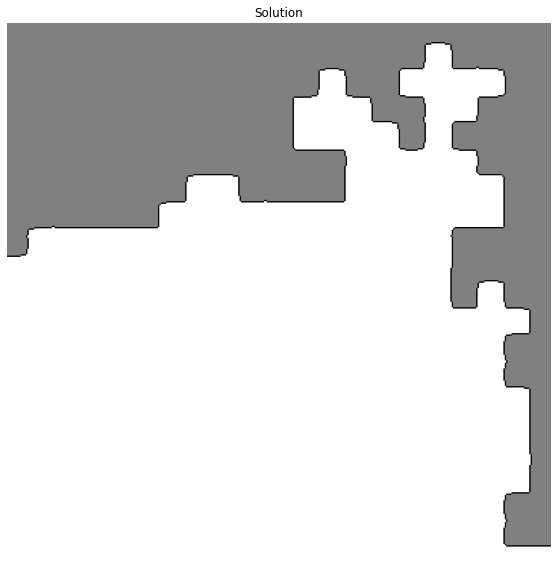

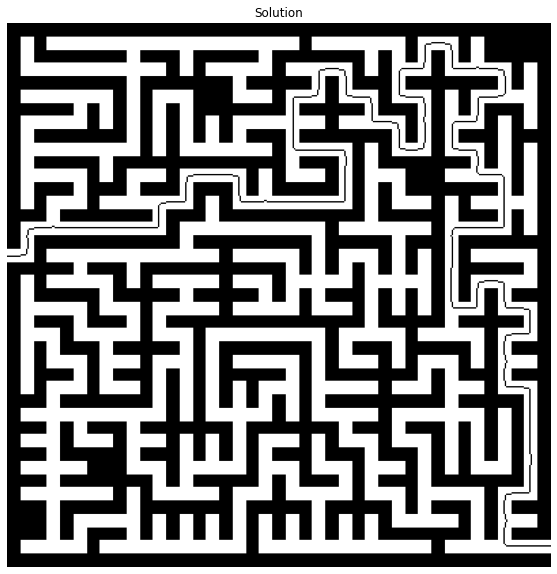

In [3]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import distance_transform_edt
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

%matplotlib inline

img = imageio.imread('images/maze2.png', pilmode = 'L') # 'maze1.png' or 'maze2.png'

result = img[:, :, np.newaxis].repeat(3, 2)

distance=distance_transform_edt(img, sampling=None, return_distances=True, return_indices=False, distances=None, indices=None)

pathway = watershed(distance, markers=None, connectivity=1, offset=None, mask=None, compactness=0, watershed_line=True)

plt.figure(figsize=(10, 10))
plt.title('Solution')
plt.axis('off')
plt.gray()
plt.imshow(pathway)
plt.show()

pathway=pathway==0

result=img+pathway

plt.figure(figsize=(10, 10))
plt.title('Solution')
plt.axis('off')
plt.gray()
plt.imshow(result)
plt.show()

## Assignment 3: $k$-means segmentation [5 Points]


**a)** Explain the idea of $k$-means clustering and how it can be used for segmentation.

k-means clustering could be discribed as an optimation algorithem with that we try to reduce the error measure of cluster-vektors towards a to be chosen number of clusters. 

**b)** Implement k-means clustering for color segmentation of an RGB image (no use of `scipy.cluster.vq.kmeans` or similar functions allowed here, but you may use functions like `numpy.mean`, `scipy.spatial.distance.pdist` and similar utility functions). Stop calculation when center vectors do not change more than a predefined threshold. Avoid empty clusters by re-initializing the corresponding center vector. (Empirically) determine a good value for $k$ for clustering the image 'peppers.png'.
**Bonus** If you want you can visualize the intermediate steps of the clustering process.

First lets take a look at how our image looks in RGB colorspace. 

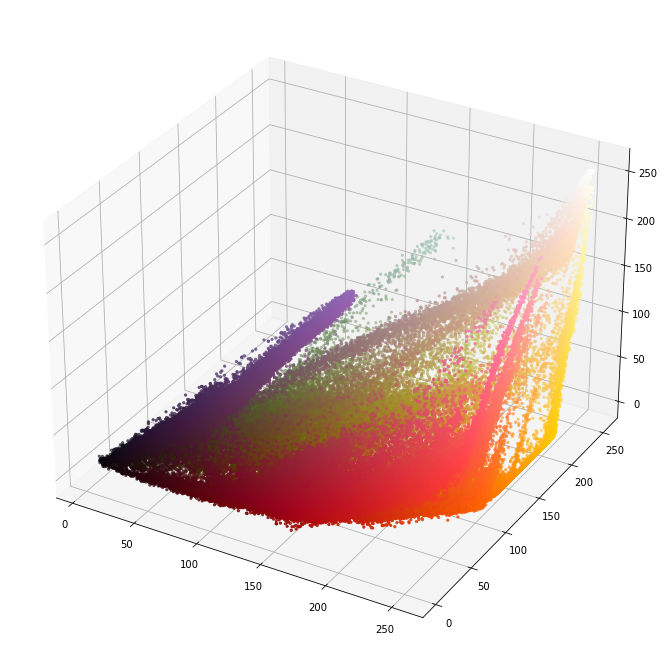

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from imageio import imread
import matplotlib.pyplot as plt
%matplotlib inline

img = imread('images/peppers.png')
vec = img.reshape((-1, img.shape[2]))
vec_scaled = vec / 255
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ret = ax.scatter(vec[:, 0], vec[:, 1], vec[:, 2], c=vec_scaled, marker='.')

In [5]:
import numpy as np
from scipy.spatial import distance
from IPython import display
from imageio import imread
import time
import matplotlib.pyplot as plt
%matplotlib inline


def kmeans_rgb(img, k, threshold=0, do_display=None):
    """
    k-means clustering in RGB space.

    Args:
        img (numpy.ndarray): an RGB image
        k (int): the number of clusters
        threshold (float): Maximal change for convergence criterion.
        do_display (bool): Whether or not to plot, intermediate steps.
        
    Results:
        cluster (numpy.ndarray): an array of the same size as `img`,
            containing for each pixel the cluster it belongs to
        centers (numpy.ndarray): 'number of clusters' x 3 array. 
            RGB color for each cluster center.
    """
    # YOUR CODE HERE


img = imread('images/peppers.png')

cluster, centers = kmeans_rgb(img, k=7, threshold=0, do_display=True)
plt.imshow(centers[cluster])
plt.show()

TypeError: cannot unpack non-iterable NoneType object

**c)** Now do the same in the HSV space (remember its special topological structure). Check if you can improve the results by ignoring some of the HSV channels.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from skimage import color
from imageio import imread
%matplotlib inline
# from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

img = imread('images/peppers.png', pilmode = 'RGB')

def kmeans_hsv(img, k, threshold = 0):
    """
    k-means clustering in HSV space.

    Args:
        img (numpy.ndarray): an HSV image
        k (int): the number of clusters
        threshold (float): 
        
    Results:
        cluster (numpy.ndarray): an array of the same size as `img`,
            containing for each pixel the cluster it belongs to
        centers (numpy.ndarray): an array
    """
    # YOUR CODE HERE
    return cluster, centers


img_hsv = color.rgb2hsv(img)
k = 7
theta = 0.01

cluster, centers_hsv = kmeans_hsv(img_hsv[:,:,:], k, theta)
if (centers_hsv.shape[1] == 3):
    plt.imshow(color.hsv2rgb(centers_hsv[cluster]))
else:
    plt.gray()
    plt.imshow(np.squeeze(centers_hsv[cluster]))
plt.show()


NameError: name 'cluster' is not defined

## Assignment 4: Interactive Region Growing [5 Points]

Implement flood fill as described in (CV07 slides 123ff.).

In a recursive implementation the floodfill function is called for the seed pixel. In the function a recursive call for the four neighbouring pixels is made, if the color of the pixel, the function is called with, is similar to the seed color. If this is the case the pixel is added to the region. [Other](https://en.wikipedia.org/wiki/Flood_fill) more elegant solutions exist aswell.

The function `on_press` is called when a mouse button is pressed inside the canvas. From there call `floodfill`. Use the filtered hsv image `img_filtered` for your computation, and show the computed region around the seed point (the position where the mousebutton was pressed) in the original image. You may use a mask to save which pixels belong the the region (and to save which pixels you already visited). 

Hint: If you can not see the image, try restarting the kernel.

<IPython.core.display.Javascript object>


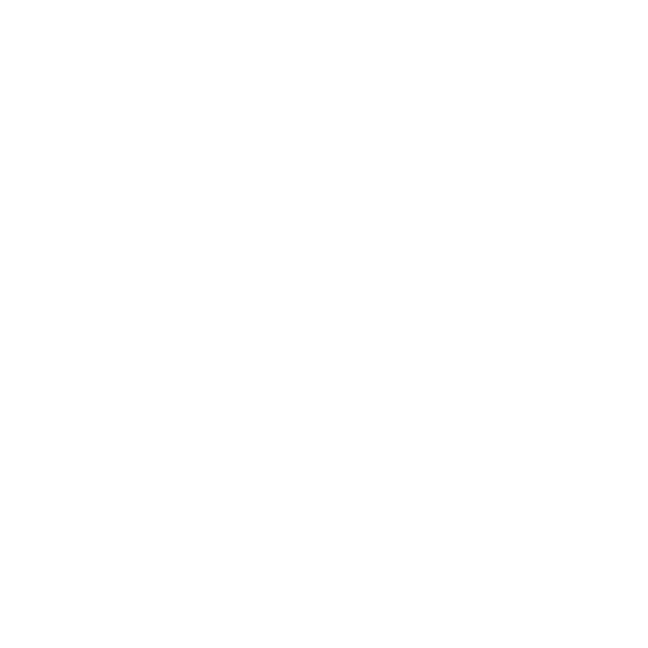

<IPython.core.display.Javascript object>


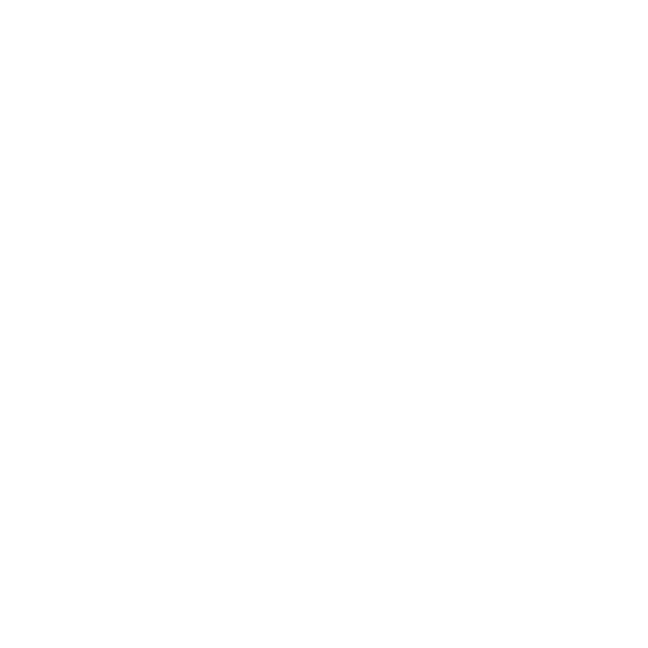

<IPython.core.display.Javascript object>


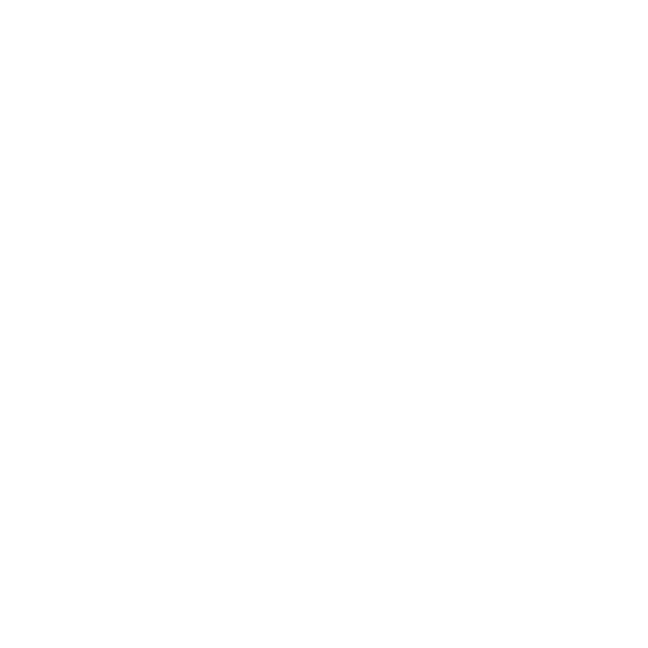

<IPython.core.display.Javascript object>


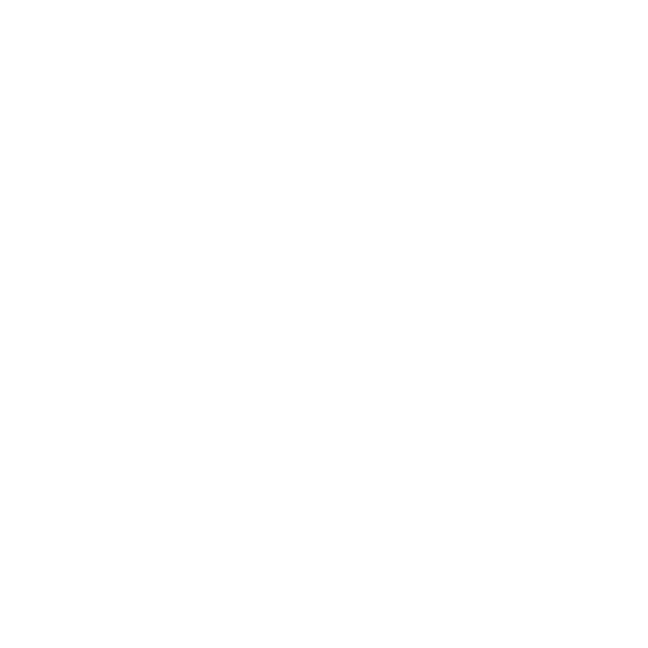

<IPython.core.display.Javascript object>


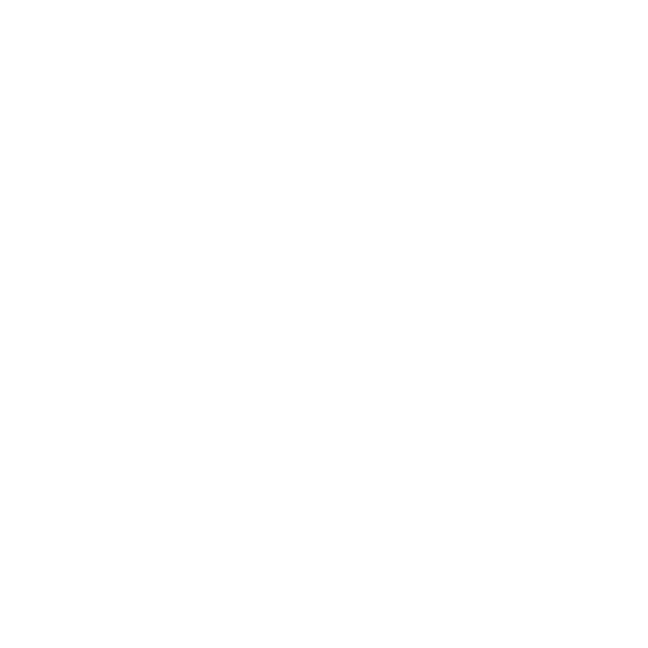

<IPython.core.display.Javascript object>


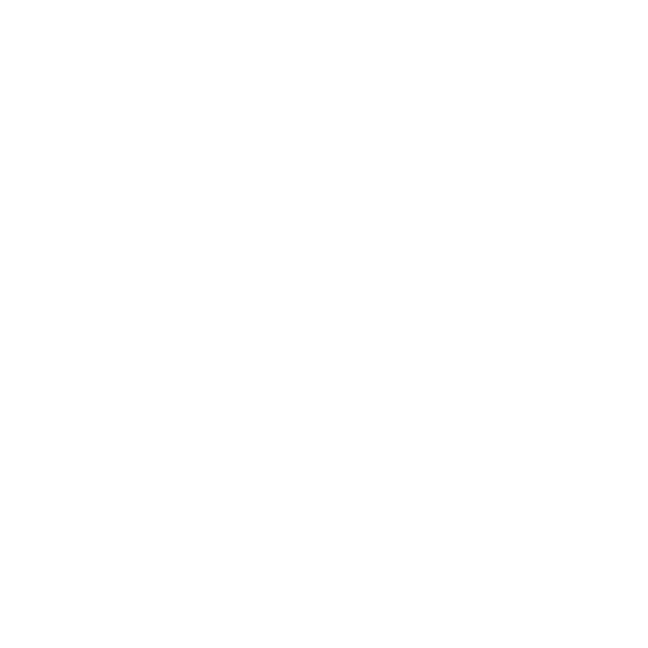

<IPython.core.display.Javascript object>


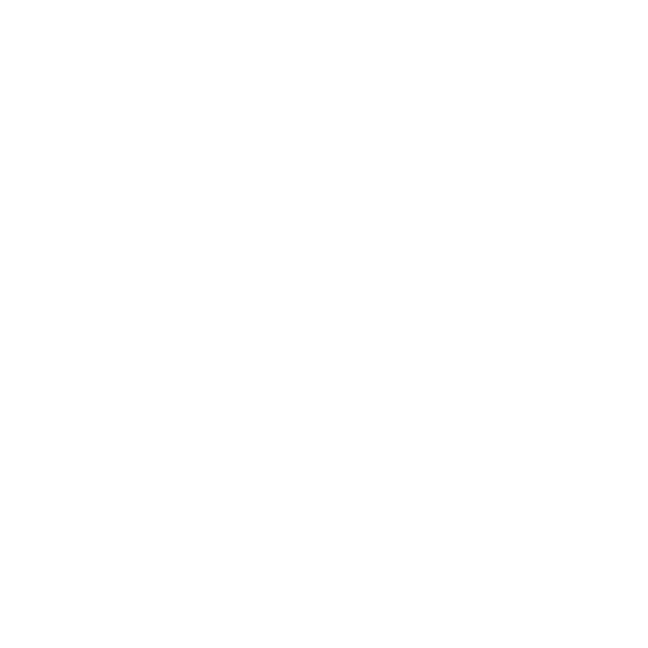

<IPython.core.display.Javascript object>


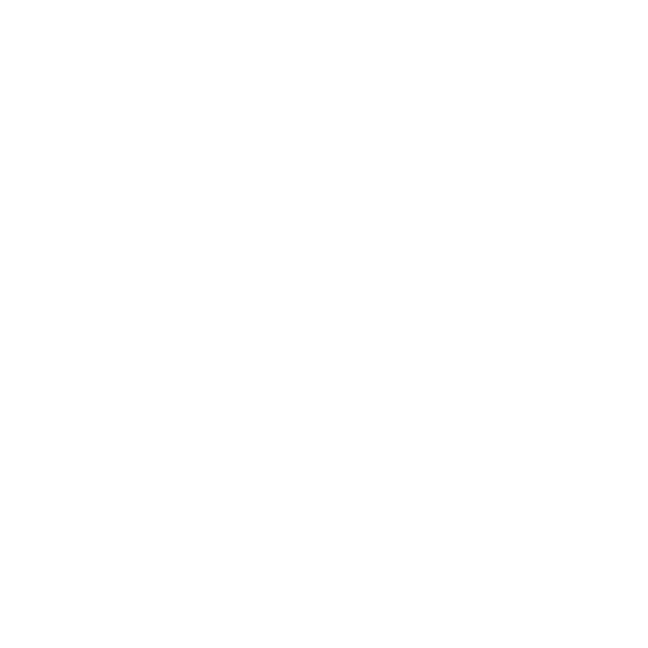

<IPython.core.display.Javascript object>


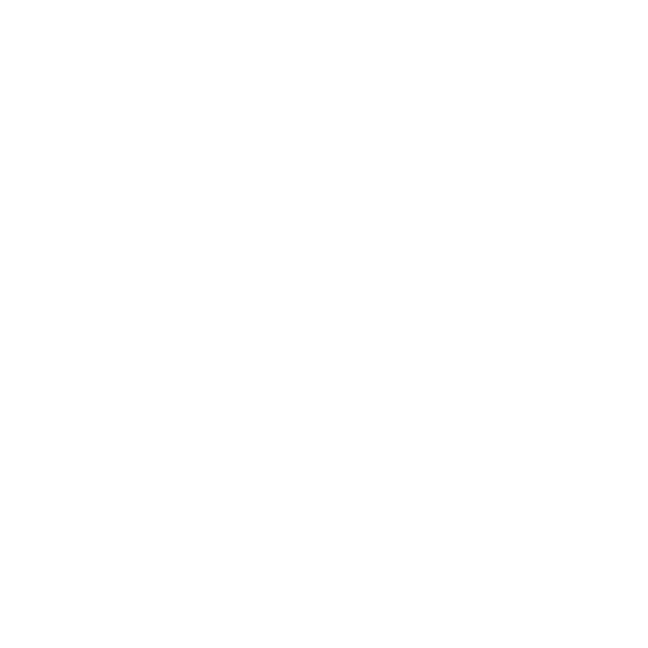

<IPython.core.display.Javascript object>


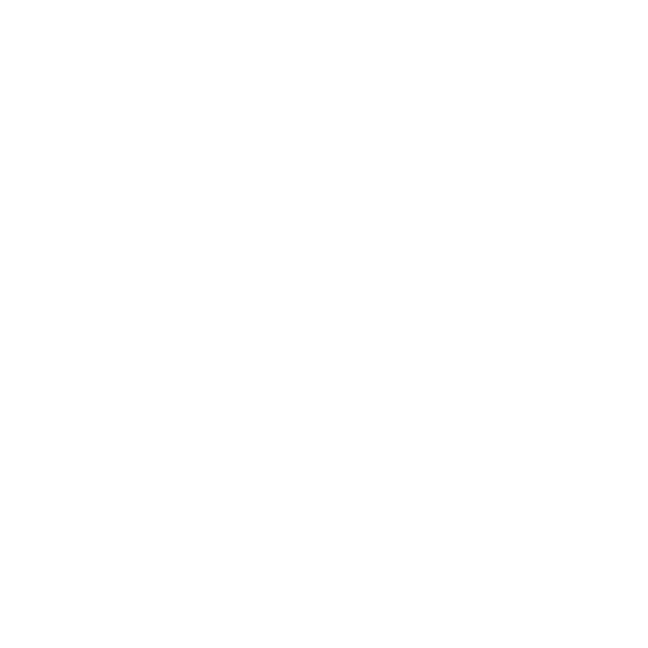

In [11]:
%matplotlib notebook
import imageio
import math
import numpy as np
from matplotlib import pyplot as plt
from skimage import color
import scipy
from sys import setrecursionlimit


threshold = .08;

setrecursionlimit(100000)

def floodfill(img, mask, x, y, color, region):
    """Recursively grows region around seed point
    
    Args: 
        img (ndarray): The image in which the region is grown
        mask (boolean ndarray): Visited pixels which belong to the region.
        x (uint): X coordinate of the pixel. Checks if this pixels belongs to the region
        y (uint): Y coordinate of the pixel.
        color (list): The color at the seed position
    """
    
    #print(x,y,color)
    
  
    plt.figure(figsize=(10,10))        
    plt.imshow(img)
    row=x
    column=y
    
    tolerance=0.1
    
    i=0
    j=0
    while np.allclose(img[row+j][column],img[row][column], rtol=tolerance, atol=tolerance)==True: 
        while np.allclose(img[row+j][column+i],img[row][column], rtol=tolerance, atol=tolerance)==True: 
            i=i+1
            #print(img[row][column-i])
            mask[row+j][column+i]=1
        j=j+1
        i=0
        
    plt.figure(figsize=(10,10))        
    plt.gray()
    plt.imshow(mask)
        
    i=0
    j=0

    while np.allclose(img[row-j][column],img[row][column], rtol=tolerance, atol=tolerance)==True: 
        while np.allclose(img[row-j][column+i],img[row][column], rtol=tolerance, atol=tolerance)==True: 
            i=i+1
            #print(img[row][column-i])
            mask[row-j][column+i]=1
        j=j+1
        i=0
        
    plt.figure(figsize=(10,10))        
    plt.gray()
    plt.imshow(mask)
    
    i=0
    j=0
    
    while np.allclose(img[row+j][column],img[row][column], rtol=tolerance, atol=tolerance)==True: 
        while np.allclose(img[row+j][column-i],img[row][column], rtol=tolerance, atol=tolerance)==True: 
            i=i+1
            #print(img[row][column-i])
            mask[row+j][column-i]=1
        j=j+1
        i=0
        
    plt.figure(figsize=(10,10))        
    plt.gray()
    plt.imshow(mask)
    
    i=0
    j=0
    
    while np.allclose(img[row-j][column],img[row][column], rtol=tolerance, atol=tolerance)==True: 
        while np.allclose(img[row-j][column-i],img[row][column], rtol=tolerance, atol=tolerance)==True: 
            i=i+1
            #print(img[row][column-i])
            mask[row-j][column-i]=1
        j=j+1
        i=0
        
    i=0
    j=0    

    
    mask=1-mask
        
    plt.figure(figsize=(10,10))        
    plt.gray()
    plt.imshow(mask)
    

def fill_from_pixel(img, img_filtered, x,y):
    """ Calls floodfill from a pixel position
    
    Args:
        img (ndarray): IO image on which fill is drawn.
        img_filtered (ndarray): Processing image on which floodfill is computed.
        x (uint): Coordinates of pixel position.
        y (uint): Coordinates of pixel position.

    Returns:
        img (ndarray): Image with grown area in white
    """
    mask = np.zeros((img.shape[0],img.shape[1]), np.bool_)
    region = np.zeros((img.shape[0],img.shape[1]), np.bool_)
    color = img_filtered[x,y, :]
    floodfill(img_filtered, mask, x, y, color, region)
    #img[region] = (255,255,255)
    
    return img


img = imageio.imread('images/peppers.png')
img_hsv = color.rgb2hsv(img)
img_filtered = scipy.ndimage.median_filter(img_hsv, 5)
img = fill_from_pixel(img, img_filtered, 200, 300) # Comment in to deactivate simple testing at fixed position